In [53]:
import sys
import datetime
sys.path.append('..')
from models import I3D_movement as I3D
from importlib import reload
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

import numpy as np
from tensorflow.keras.optimizers import Adam

import configparser
config = configparser.ConfigParser()
config.read('../config.ini')

EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001

In [2]:
load_model_filename = config['model']['path']

In [3]:
X_train, X_train_mvm, y_train, X_val, X_val_mvm, y_val, X_test, X_test_mvm, y_test = I3D.load_datasets()

model = I3D.define_joint_model()

from tensorflow import keras
#model.compile(loss='categorical_crossentropy', optimizer = Adam(learning_rate=LEARNING_RATE), metrics=["accuracy"]) 
model.compile(optimizer= 'adam' , loss= keras.losses.binary_crossentropy, metrics=['accuracy']) #error fix

train_data = I3D.DataGenerator(X_train, X_train_mvm, y_train, BATCH_SIZE, True, 10, 0, 0)
val_data = I3D.DataGenerator(X_val, X_val_mvm, y_val, BATCH_SIZE)
test_data = I3D.DataGenerator(X_test, X_test_mvm, y_test, BATCH_SIZE)

current_time = datetime.datetime.now().isoformat().replace(":", "-")

model.load_weights(load_model_filename)

# Evaluating the final model on the test set
# Model expects 32x32 images not 24x24; not sure what was done without this.
X_test_padded = np.pad(X_test, ((0,0), (0,0), (4,4), (4,4), (0,0)))
X_val_padded = np.pad(X_val, ((0,0), (0,0), (4,4), (4,4), (0,0)))
val_predictions = model.predict([X_val_padded, X_val_mvm])
predictions = model.predict([X_test_padded, X_test_mvm])
y_pred = np.argmax(predictions, axis = 1)
y_test = np.argmax(y_test, axis = 1)

Dataset loading.. Dataset loaded!


In [62]:
y_pred_conf = np.max(predictions, axis=1)
size = len(y_pred)

confusion = confusion_matrix(y_test, y_pred)
confidence_matrix = np.zeros((13,13))

for i in range(size):
	confidence_matrix[y_test[i]][y_pred[i]] += y_pred_conf[i]

norm_conf_matrix = np.divide(confidence_matrix.round(decimals=4), confusion, where =confusion!=0)
norm_conf_matrix[norm_conf_matrix < 0.001] = 0

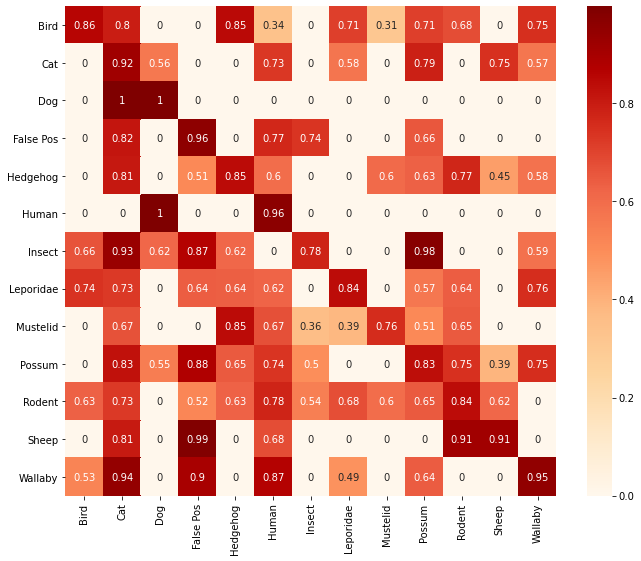

In [65]:
fig, ax = plt.subplots(figsize=(11, 9))
labs = ["Bird","Cat","Dog","False Pos","Hedgehog","Human","Insect","Leporidae","Mustelid","Possum","Rodent","Sheep","Wallaby"]
sns.heatmap(norm_conf_matrix, annot=True,cmap="OrRd",xticklabels=labs,yticklabels=labs)
plt.show()

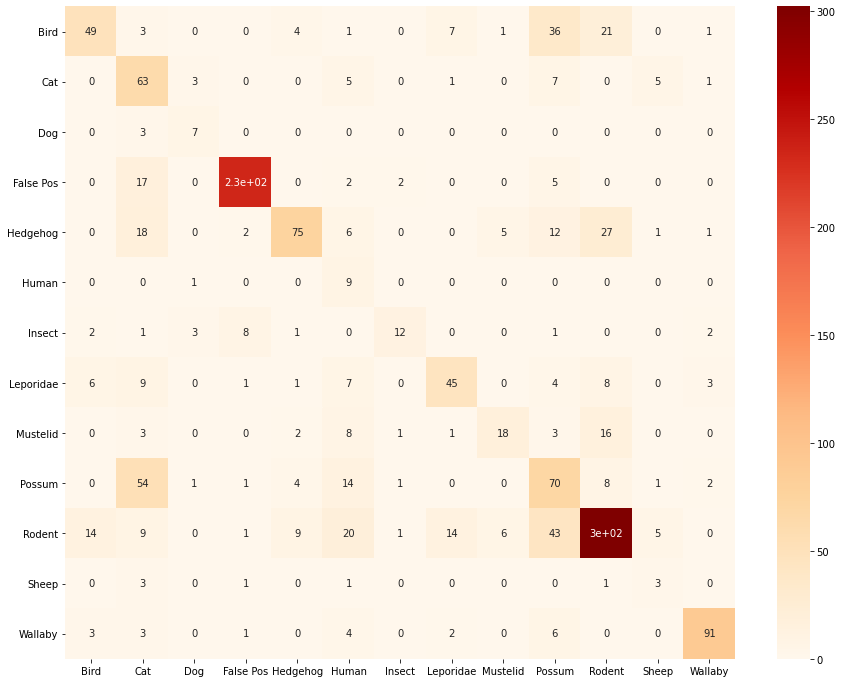

In [68]:
fig, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(confusion, annot=True,cmap="OrRd",xticklabels=labs,yticklabels=labs)
plt.show()

In [7]:
missclassifications = y_pred != y_test
np.count_nonzero(missclassifications)

522

In [8]:
def divide_zeros(a, b):
    "Divide a by b, accepting 0/0=0"
    return np.divide(a, b, out=np.zeros_like(a, dtype=float), where=b!=0)

In [9]:
def plot_confidence_hists(predictions, missclassifications, axes=None, BINS=100, xmin=None, xmax=1, label=None, alpha=1, color=None, scale_cumulative=False):
    if axes is None:
        fig, axes = plt.subplots(1, 4, figsize=(16,4), dpi=100)

    # All Classifications
    axes[0].hist(np.max(predictions, axis=1), bins=BINS, label=label, alpha=alpha, color=color)
    axes[0].set_xlabel("Confidence")
    axes[0].set_ylabel("All Classifications (Count)")
    axes[0].set_xlim(xmin, xmax)
    axes[0].set_title("Confidence")

    # Misclassifications
    axes[1].hist(np.max(predictions[missclassifications], axis=1), bins=BINS, alpha=alpha, color=color)
    axes[1].set_xlabel("Confidence")
    axes[1].set_ylabel("Misclassifications (Count)")
    axes[1].set_xlim(xmin, xmax)
    axes[1].set_title("Confidence of Misclassifications")

    # Fraction of classifications at a particular confidence which are misclassifications
    # Basically the misclassifications' confidences normalized by confidence distribution
    all_bins = np.histogram(np.max(predictions, axis=1), bins=BINS)
    misclassified_bins = np.histogram(np.max(predictions[missclassifications], axis=1), bins=all_bins[1])

    axes[2].hist(all_bins[1][:-1], all_bins[1], weights=divide_zeros(misclassified_bins[0], all_bins[0]), alpha=alpha, color=color)
    axes[2].set_xlabel("Confidence")
    axes[2].set_ylabel("Misclassifications (Fraction)")
    axes[2].set_xlim(xmin, xmax)
    axes[2].set_title("Fraction of Misclassifications")

    sums = np.cumsum(divide_zeros(misclassified_bins[0], all_bins[0])[::-1])[::-1]
    
    if scale_cumulative:
        #print(all_bins[1])
        #print(sums)
        scaled_bins = (all_bins[1]-np.min(all_bins[1]))/(np.max(all_bins[1])-np.min(all_bins[1]))
    else:
        scaled_bins = all_bins[1]
    
    axes[3].hist(scaled_bins[:-1], scaled_bins, weights=sums/np.sum(sums), alpha=alpha, color=color)
    axes[3].set_xlabel("Confidence")
    axes[3].set_ylabel("Misclassifications (Fraction)")
    axes[3].set_xlim(xmin, xmax)
    axes[3].set_title("Cumulative Sum of Fraction")
    
    if axes is None:
        fig.suptitle("I3D Base Model Misclassifications by Confidience")
        fig.tight_layout()

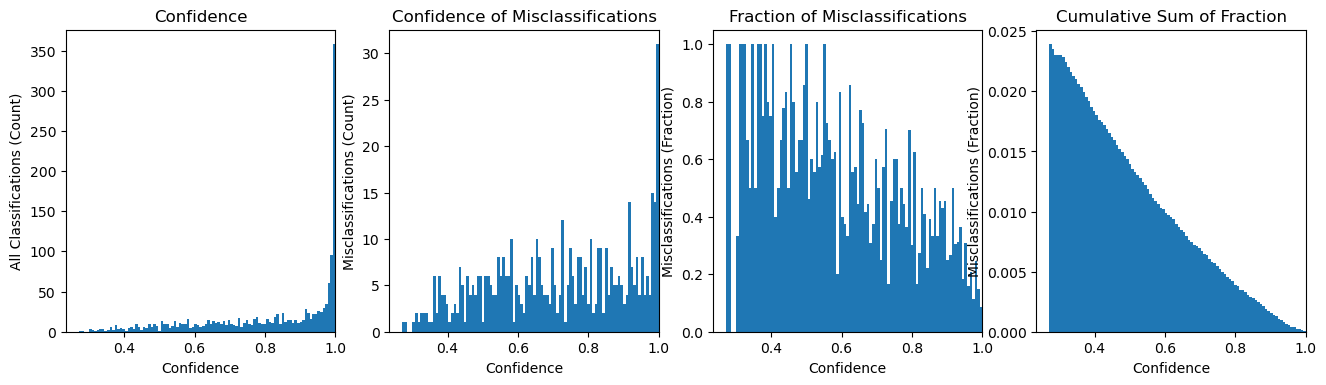

In [10]:
plot_confidence_hists(predictions, missclassifications)

In [11]:
predictions[:5]

array([[7.4085308e-04, 2.5427574e-03, 1.3645850e-03, 2.9231817e-03,
        1.1388512e-03, 4.9522653e-04, 5.7008583e-04, 3.2423516e-03,
        7.9200498e-04, 1.2002911e-03, 9.5767593e-01, 2.5335949e-02,
        1.9779503e-03],
       [1.8411310e-03, 4.2270781e-03, 3.3039204e-04, 8.3318760e-04,
        9.5238676e-03, 2.1752359e-04, 3.4737325e-04, 1.2478075e-02,
        1.1858024e-03, 3.4928876e-03, 9.6385705e-01, 1.1643379e-03,
        5.0123513e-04],
       [1.4254832e-06, 8.0832739e-05, 1.3563370e-06, 3.6349604e-08,
        9.9870920e-01, 4.7773749e-08, 1.2293830e-08, 2.0885198e-06,
        3.1218627e-07, 1.1683654e-03, 3.3796059e-05, 3.9687457e-08,
        2.5234228e-06],
       [3.4613389e-04, 9.4641410e-02, 5.5868039e-04, 2.1737099e-04,
        2.7756393e-02, 1.8129052e-04, 8.9888570e-05, 4.9401610e-04,
        9.5471488e-03, 2.5282815e-02, 8.4045345e-01, 1.3406599e-04,
        2.9734470e-04],
       [5.0360150e-08, 9.9991667e-01, 1.6629741e-05, 2.9426207e-08,
        6.3657842e-0

TODO:
* Do this for binary classification so we get the result we really care about
* Try techniques to improve it!

### Temperature Scaling

In [12]:
from temperature_scaling.temperature_scaling import find_scaling_temperature, apply_temperature_scaling, inverse_softmax

In [13]:
temperature = find_scaling_temperature(tf.constant(np.where(y_val==1)[1]), inverse_softmax(val_predictions))
temperature

1.7995979189871087

In [14]:
scaled_predictions = apply_temperature_scaling(temperature, predictions)

### Platt Binning

In [15]:
import calibration as cal
calibrator = cal.PlattBinnerMarginalCalibrator(X_val.shape[0], num_bins=100)
calibrator.train_calibration(val_predictions, np.where(y_val==1)[1])
plat_scaled_predictions = calibrator.calibrate(predictions)

ModuleNotFoundError: No module named 'calibration'

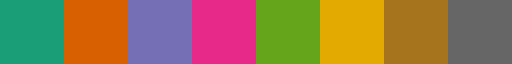

In [ ]:
cmap = plt.get_cmap('Dark2')
cmap

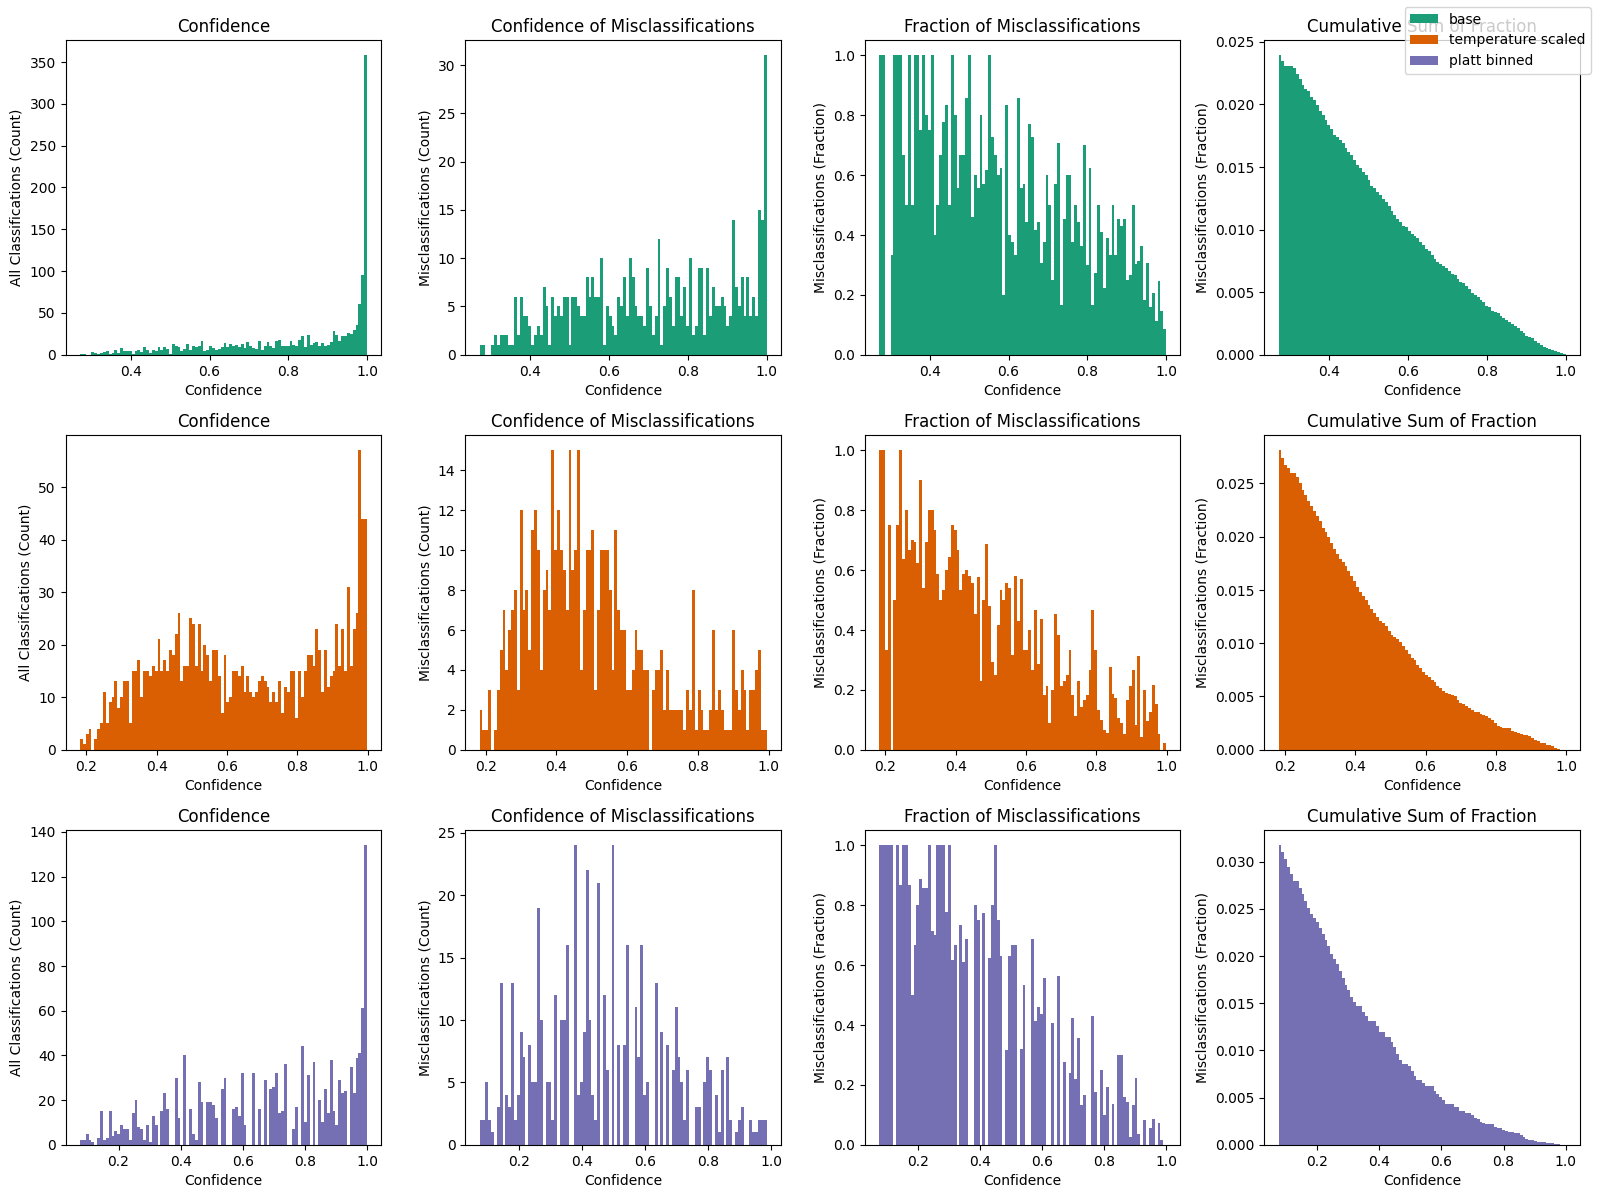

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12), dpi=100)
plot_confidence_hists(predictions, missclassifications, xmax=None, axes=axes[0], label='base', color=cmap.colors[0])
plot_confidence_hists(scaled_predictions, missclassifications, xmax=None, axes=axes[1], label='temperature scaled', color=cmap.colors[1])
plot_confidence_hists(plat_scaled_predictions, missclassifications, xmax=None, axes=axes[2], label='platt binned', color=cmap.colors[2])
fig.legend()
fig.tight_layout()

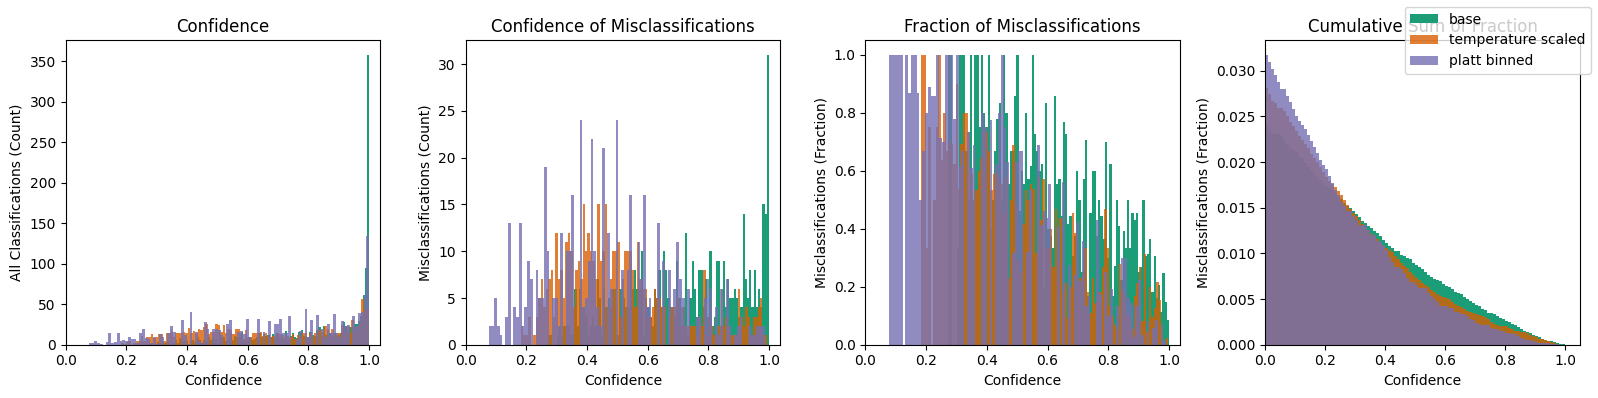

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=100)
plot_confidence_hists(predictions, missclassifications, xmax=None, axes=axes, label='base', alpha=1, xmin=0, scale_cumulative=True, color=cmap.colors[0])
plot_confidence_hists(scaled_predictions, missclassifications, xmax=None, axes=axes, label='temperature scaled',  alpha=0.8, xmin=0, scale_cumulative=True, color=cmap.colors[1])
plot_confidence_hists(plat_scaled_predictions, missclassifications, xmax=None, axes=axes, label='platt binned', alpha=0.8, xmin=0, scale_cumulative=True, color=cmap.colors[2])
fig.legend()
fig.tight_layout()

* Platt binning is better than temperature scaling, but both help a little bit
* Time to read the Platt paper & then try CCAC?